### Necessary Imports

In [2]:
# Imports
# Data handling and computation
import numpy as np
import pandas as pd
import scipy

# Machine learning and neural networks
import torch
import torch.nn as nn
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GINConv, global_mean_pool, BatchNorm
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# NLP models
from transformers import BertTokenizer, BertModel

# SQL parsing
import sqlparse
from sqlparse.sql import IdentifierList, Identifier
from sqlparse.tokens import Keyword, DML, Name, Number, String, Comparison, Wildcard
import sqlglot

# Graphs and visualization
import networkx as nx
import matplotlib.pyplot as plt
import graphviz
from IPython.display import display

/DS/venvs/work/amahajan/env_pc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Preprocessing Pipeline

#### GNN Processing 

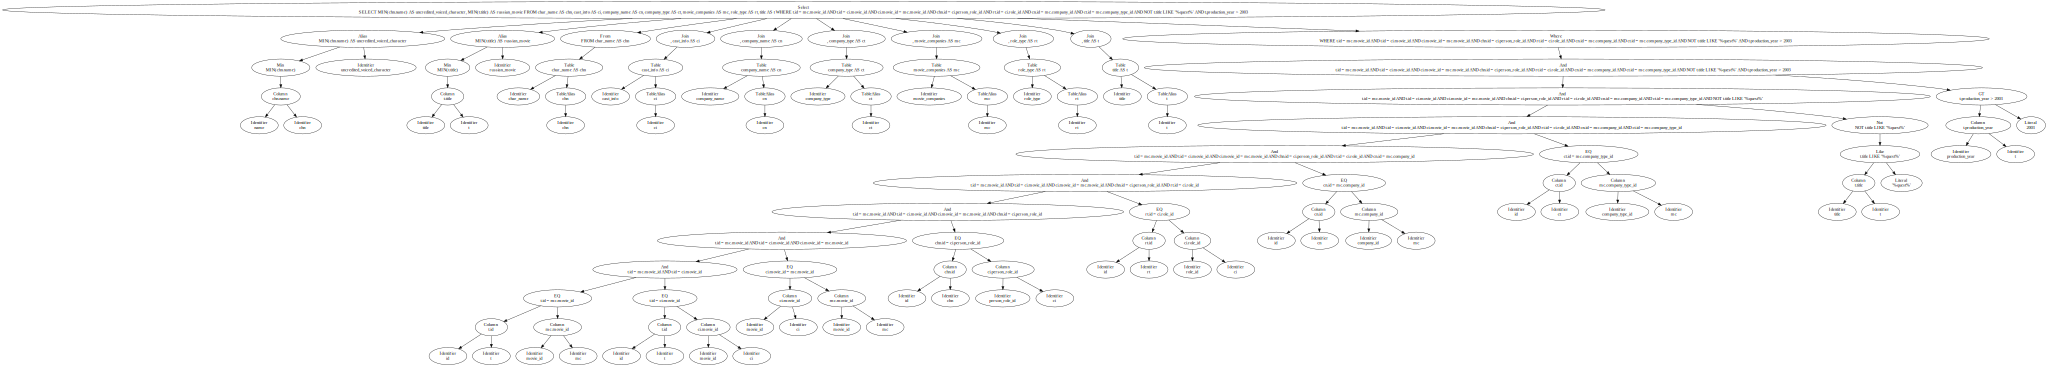

In [3]:
def parse_query_to_graph(sql_query, visualize=False):
    ast = sqlglot.parse_one(sql_query)
    G = nx.DiGraph()
    node_type_to_int = {}
    current_type_id = 0
    node_counter = 0

    def get_node_label(node):
        """Generate a label for the node that includes its type and value."""
        node_type_name = type(node).__name__
        node_value = str(node)
        return f"{node_type_name}\n{node_value}"

    def add_nodes_and_edges(node, G, parent_id=None):
        nonlocal current_type_id, node_counter
        node_type_name = type(node).__name__

        if node_type_name not in node_type_to_int:
            node_type_to_int[node_type_name] = current_type_id
            current_type_id += 1

        node_id = node_counter
        node_counter += 1
        node_features = [node_type_to_int[node_type_name]]
        node_label = get_node_label(node)
        G.add_node(node_id, label=node_label, features=node_features)

        if parent_id is not None:
            G.add_edge(parent_id, node_id)

        for child in node.args.values():
            if isinstance(child, list):
                for item in child:
                    if isinstance(item, sqlglot.expressions.Expression):
                        add_nodes_and_edges(item, G, node_id)
            elif isinstance(child, sqlglot.expressions.Expression):
                add_nodes_and_edges(child, G, node_id)

    add_nodes_and_edges(ast, G)

    # Optional visualization
    if visualize:
        dot = graphviz.Digraph(format='png')
        for node, attrs in G.nodes(data=True):
            dot.node(str(node), label=attrs['label'])
        for src, dst in G.edges():
            dot.edge(str(src), str(dst))
        display(dot)

    # Extract node features and create edge index from the normalized node IDs
    node_features = [G.nodes[node]['features'] for node in G.nodes()]
    node_features_tensor = torch.tensor(node_features, dtype=torch.float)
    node_features_tensor = normalize_features(node_features_tensor)  # Normalize features (See if this works)
    edge_list = [(src, dst) for src, dst in G.edges()]
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    
    return Data(x=node_features_tensor, edge_index=edge_index)

def create_graph_data(sql_query, visualize=False):
    return parse_query_to_graph(sql_query, visualize)


def normalize_features(features):
    # Standardize features to have zero mean and unit variance
    mean = features.mean(dim=0, keepdim=True)
    std = features.std(dim=0, keepdim=True)
    normalized_features = (features - mean) / (std + 1e-6)  # Adding epsilon to avoid division by zero
    return normalized_features


# Example usage:
sql_query = " SELECT MIN(chn.name) AS uncredited_voiced_character, MIN(t.title) AS russian_movie FROM char_name AS chn, cast_info AS ci, company_name AS cn, company_type AS ct, movie_companies AS mc, role_type AS rt, title AS t WHERE t.id = mc.movie_id AND t.id = ci.movie_id AND ci.movie_id = mc.movie_id AND chn.id = ci.person_role_id AND rt.id = ci.role_id AND cn.id = mc.company_id AND ct.id = mc.company_type_id AND t.title not like '%quest%' AND t.production_year > 2003 "

graph_data = create_graph_data(sql_query, visualize=True)



#### Transformer Processing

In [4]:


# Load the pre-trained BERT tokenizer (adjust model name if using a specific BERT variant)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocess_text_for_bert(sql_queries, max_length=512):
    """
    Preprocess SQL queries for BERT inputs.

    Args:
    sql_queries (list of str): List of SQL query strings.
    max_length (int): Maximum length of tokens for BERT input.

    Returns:
    dict: Dictionary containing input IDs and attention masks.
    """
    # Tokenize and encode the SQL queries
    encoded_batch = tokenizer(
        sql_queries,                      # List of SQL queries
        padding=True,                     # Pad to longest in batch
        truncation=True,                  # Truncate to max_length
        max_length=max_length,            # Specified max length
        return_tensors="pt"               # Return PyTorch tensors
    )
    
    return {
        'input_ids': encoded_batch['input_ids'],        # Token IDs
        'attention_mask': encoded_batch['attention_mask']  # Attention masks
    }

# Example usage
sql_queries = ["SELECT * FROM customers WHERE age > 25", "SELECT id, name FROM products"]
preprocessed_data = preprocess_text_for_bert(sql_queries)


### Passing Data through Pipeline

In [5]:
def load_data(file_path):
    data = pd.read_csv(file_path)
    return data['Query Text']  # Assuming the SQL queries are stored in this column

def prepare_data(file_path):
    queries = load_data(file_path)
    bert_inputs = preprocess_text_for_bert(list(queries), max_length=512)
    graph_data_list = [create_graph_data(query) for query in queries]
    return bert_inputs, graph_data_list

# Example file path
file_path = r"/DS/venvs/work/amahajan/prediction_cardinality/query_cardinalities.csv"
bert_inputs, graph_data_list = prepare_data(file_path)

# Example of checking one data point
print("BERT Input IDs:", bert_inputs['input_ids'][0])
print("BERT Attention Mask:", bert_inputs['attention_mask'][0])
print("Graph Data:", graph_data_list[0])


BERT Input IDs: tensor([  101,  7276,  8117,  1006, 10381,  2078,  1012,  2171,  1007,  2004,
         8104,  1035,  6126,  1035,  2839,  1010,  8117,  1006,  1056,  1012,
         2516,  1007,  2004,  2845,  1035,  3185,  2013, 25869,  1035,  2171,
         2004, 10381,  2078,  1010,  3459,  1035, 18558,  2004, 25022,  1010,
         2194,  1035,  2171,  2004, 27166,  1010,  2194,  1035,  2828,  2004,
        14931,  1010,  3185,  1035,  3316,  2004, 11338,  1010,  2535,  1035,
         2828,  2004, 19387,  1010,  2516,  2004,  1056,  2073,  1056,  1012,
         8909,  1027, 11338,  1012,  3185,  1035,  8909,  1998,  1056,  1012,
         8909,  1027, 25022,  1012,  3185,  1035,  8909,  1998, 25022,  1012,
         3185,  1035,  8909,  1027, 11338,  1012,  3185,  1035,  8909,  1998,
        10381,  2078,  1012,  8909,  1027, 25022,  1012,  2711,  1035,  2535,
         1035,  8909,  1998, 19387,  1012,  8909,  1027, 25022,  1012,  2535,
         1035,  8909,  1998, 27166,  1012,  8909

### Model Architecture

In [6]:


class ResidualGNN(nn.Module):
    def __init__(self, num_node_features):
        super(ResidualGNN, self).__init__()
        self.conv1 = GINConv(nn.Sequential(
            nn.Linear(num_node_features, 64),
            nn.ReLU(),
            nn.Linear(64, 64)
        ))
        self.conv2 = GINConv(nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64)
        ))
        self.bn1 = BatchNorm(64)
        self.bn2 = BatchNorm(64)
        self.pool = global_mean_pool  # Mean pooling
        self.identity_transform = nn.Linear(num_node_features, 64)  # Transform to match dimensions

    def forward(self, x, edge_index, batch):
        identity = self.identity_transform(x)  # Transform initial features to match dimensions
        x = self.conv1(x, edge_index)
        x = self.bn1(x + identity)  # Adding skip connection

        identity = x  # Update identity to current x before second GINConv
        x = self.conv2(x, edge_index)
        x = self.bn2(x + identity)  # Adding skip connection

        x = self.pool(x, batch)
        return x

class SQLCardinalityEstimator(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased', num_node_features=1):
        super(SQLCardinalityEstimator, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.gnn = ResidualGNN(num_node_features)
        self.fusion_layer = nn.Linear(self.bert.config.hidden_size + 64, 512)  # Ensure dimensions match
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(512, 1)

    def forward(self, input_ids, attention_mask, graph_data):
        # Processing with BERT
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_bert_output = bert_output.pooler_output
        
        # Processing with Residual GNN
        graph_features = self.gnn(graph_data.x, graph_data.edge_index, graph_data.batch)
        
        # Combining features from BERT and GNN
        combined_features = torch.cat([pooled_bert_output, graph_features], dim=1)
        combined_features = self.relu(self.fusion_layer(combined_features))
        
        # Final output
        cardinality_estimate = self.output_layer(combined_features)
        return cardinality_estimate
    

# Example instantiation and forward pass (pseudo-code)
model = SQLCardinalityEstimator()



### Data Loader & Model Training

In [7]:
class SQLQueryDataset(Dataset):
    def __init__(self, csv_file, scaler=None):
        self.dataframe = pd.read_csv(csv_file)
        self.scaler = scaler

        if self.scaler is not None:
            # Assuming the cardinality values are in the 'Cardinality' column
            cardinality_values = self.dataframe['Cardinality'].values.reshape(-1, 1)
            self.dataframe['Scaled_Cardinality'] = self.scaler.fit_transform(cardinality_values)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        sql_query = self.dataframe.iloc[idx]['Query Text']
        
        if self.scaler is not None: 
            target = torch.tensor([self.dataframe.iloc[idx]['Scaled_Cardinality']], dtype=torch.float) 
        else: 
            target = torch.tensor([self.dataframe.iloc[idx]['Cardinality']], dtype=torch.float)

        bert_inputs = preprocess_text_for_bert([sql_query], max_length=512)
        graph_data = create_graph_data(sql_query)

        # Extract input_ids, attention_mask from bert_inputs and graph data structure
        input_ids = bert_inputs['input_ids'].squeeze(0)  # Remove batch dimension
        attention_mask = bert_inputs['attention_mask'].squeeze(0)
        
        # Embed target into the graph_data for training
        graph_data.y = target        
        return input_ids, attention_mask, graph_data
    

def collate_fn(batch):
    input_ids = [item[0] for item in batch]
    attention_mask = [item[1] for item in batch]
    graph_data_list = [item[2] for item in batch]

    # Pad the sequences to the maximum length in the batch
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=0)
    attention_mask_padded = pad_sequence(attention_mask, batch_first=True, padding_value=0)

    # Batch all graph data objects into a single batch
    graph_data_batch = Batch.from_data_list(graph_data_list)
    
    # Assuming graph_data_list does not need padding as each graph is independent
    return input_ids_padded, attention_mask_padded, graph_data_batch


# Example usage:
scaler = StandardScaler()
# Load your data
full_dataset = SQLQueryDataset(csv_file=file_path, scaler=scaler)

# Split data indices into training and testing
train_idx, test_idx = train_test_split(range(len(full_dataset)), test_size=0.15, random_state=42)

# Create training and testing subsets
train_dataset = Subset(full_dataset, train_idx)
test_dataset = Subset(full_dataset, test_idx)

# Create data loaders for both sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)


In [8]:
print(graph_data.x.shape)  # Should output something like [number_of_nodes, 1]


torch.Size([117, 1])


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SQLCardinalityEstimator().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)
criterion = torch.nn.MSELoss()
mae_criterion = torch.nn.L1Loss()

for epoch in range(200):
    model.train()
    predictions = []
    targets = []
    total_loss = 0  # To calculate average loss per epoch
    total_mae = 0  # To calculate average MAE per epoch
    
    for input_ids, attention_mask, graph_data in train_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        graph_data = graph_data.to(device)  # Ensure graph data and its components are on the same device

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, graph_data)
        outputs = outputs.squeeze(-1)  # Squeeze the output to match the target shape [batch_size]
        
        mse_loss = criterion(outputs, graph_data.y)
        mae_loss = mae_criterion(outputs, graph_data.y)  # Calculate MAE

        mse_loss.backward()
        optimizer.step()

        total_loss += mse_loss.item()
        total_mae += mae_loss.item()

        predictions.extend(outputs.detach().cpu().numpy())
        targets.extend(graph_data.y.detach().cpu().numpy())

    avg_loss = total_loss / len(train_loader)
    avg_mae = total_mae / len(train_loader)
    r2 = r2_score(targets, predictions) 

    print(f'Epoch {epoch+1}, Average MSE Loss: {avg_loss:.4f}, Average MAE: {avg_mae:.4f}, R² Score: {r2:.4f}')


Epoch 1, Average MSE Loss: 0.9597, Average MAE: 0.1379, R² Score: 0.0014
Epoch 2, Average MSE Loss: 0.9494, Average MAE: 0.1375, R² Score: 0.0120
Epoch 3, Average MSE Loss: 0.9410, Average MAE: 0.1410, R² Score: 0.0207
Epoch 4, Average MSE Loss: 0.9315, Average MAE: 0.1399, R² Score: 0.0307
Epoch 5, Average MSE Loss: 0.9230, Average MAE: 0.1353, R² Score: 0.0394
Epoch 6, Average MSE Loss: 0.9296, Average MAE: 0.1281, R² Score: 0.0390
Epoch 7, Average MSE Loss: 0.9215, Average MAE: 0.1396, R² Score: 0.0410
Epoch 8, Average MSE Loss: 0.9032, Average MAE: 0.1141, R² Score: 0.0601
Epoch 9, Average MSE Loss: 0.9000, Average MAE: 0.1163, R² Score: 0.0634
Epoch 10, Average MSE Loss: 0.9297, Average MAE: 0.1338, R² Score: 0.0542
Epoch 11, Average MSE Loss: 0.8978, Average MAE: 0.1201, R² Score: 0.0697
Epoch 12, Average MSE Loss: 0.8878, Average MAE: 0.1102, R² Score: 0.0763
Epoch 13, Average MSE Loss: 0.8919, Average MAE: 0.1107, R² Score: 0.0759
Epoch 14, Average MSE Loss: 0.8898, Average MAE

In [10]:
def evaluate_model(model, loader, criterion, mae_criterion, device):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # No gradients needed for evaluation
        total_mse = 0
        total_mae = 0
        predictions = []
        targets = []
        
        for input_ids, attention_mask, graph_data in loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            graph_data = graph_data.to(device)

            outputs = model(input_ids, attention_mask, graph_data)
            outputs = outputs.squeeze(-1)
            
            mse_loss = criterion(outputs, graph_data.y)
            mae_loss = mae_criterion(outputs, graph_data.y)

            total_mse += mse_loss.item()
            total_mae += mae_loss.item()

            predictions.extend(outputs.cpu().detach().numpy())
            targets.extend(graph_data.y.cpu().detach().numpy())

        avg_mse = total_mse / len(loader)
        avg_mae = total_mae / len(loader)
        r2 = r2_score(targets, predictions)

    print(f'Evaluation Results - MSE: {avg_mse:.4f}, MAE: {avg_mae:.4f}, R² Score: {r2:.4f}')

# Call the evaluation function after the training loop
evaluate_model(model, test_loader, criterion, mae_criterion, device)


Evaluation Results - MSE: 0.5651, MAE: 0.0908, R² Score: 0.5145


In [61]:
class GNNOnlyModel(nn.Module):
    def __init__(self, num_node_features=1):
        super(GNNOnlyModel, self).__init__()
        self.gnn = ResidualGNN(num_node_features)
        self.output_layer = nn.Linear(64, 1)  # Output layer after GNN

    def forward(self, graph_data):
        graph_features = self.gnn(graph_data.x, graph_data.edge_index, graph_data.batch)
        return self.output_layer(graph_features)


In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GNNOnlyModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
mse_criterion = torch.nn.MSELoss()
mae_criterion = torch.nn.L1Loss()

for epoch in range(3):
    model.train()
    predictions = []
    targets = []
    total_loss = 0  # To calculate average loss per epoch
    total_mae = 0  # To calculate average MAE per epoch
    
    for input_ids, attention_mask, graph_data in train_loader:
        graph_data = graph_data.to(device)  # Ensure graph data and its components are on the same device

        optimizer.zero_grad()
        outputs = model(graph_data)
        outputs = outputs.squeeze(-1)  # Squeeze the output to match the target shape [batch_size]
        
        mse_loss = criterion(outputs, graph_data.y)
        mae_loss = mae_criterion(outputs, graph_data.y)  # Calculate MAE

        mse_loss.backward()
        optimizer.step()

        total_loss += mse_loss.item()
        total_mae += mae_loss.item()

        predictions.extend(outputs.detach().cpu().numpy())
        targets.extend(graph_data.y.detach().cpu().numpy())

    avg_loss = total_loss / len(train_loader)
    avg_mae = total_mae / len(train_loader)
    r2 = r2_score(targets, predictions) 

    print(f'Epoch {epoch+1}, Average MSE Loss: {avg_loss:.4f}, Average MAE: {avg_mae:.4f}, R² Score: {r2:.4f}')


Epoch 1, Average MSE Loss: 0.9983, Average MAE: 0.8618, R² Score: -0.0010
Epoch 2, Average MSE Loss: 0.9975, Average MAE: 0.8710, R² Score: -0.0001
Epoch 3, Average MSE Loss: 0.9974, Average MAE: 0.8705, R² Score: -0.0001


In [63]:
# Assuming you have a test_loader set up similarly
def evaluate_model(model, loader):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # No gradients needed for evaluation
        total_mse = 0
        total_mae = 0
        predictions = []
        targets = []
        
        for input_ids, attention_mask, graph_data in loader:

            graph_data = graph_data.to(device)

            outputs = model(graph_data)
            outputs = outputs.squeeze(-1)
            
            mse_loss = criterion(outputs, graph_data.y)
            mae_loss = mae_criterion(outputs, graph_data.y)

            total_mse += mse_loss.item()
            total_mae += mae_loss.item()

            predictions.extend(outputs.cpu().numpy())
            targets.extend(graph_data.y.cpu().numpy())

        avg_mse = total_mse / len(loader)
        avg_mae = total_mae / len(loader)
        r2 = r2_score(targets, predictions)

    print(f'Evaluation Results - MSE: {avg_mse:.4f}, MAE: {avg_mae:.4f}, R² Score: {r2:.4f}')

# Call the evaluation function after the training loop
evaluate_model(model, test_loader)

Evaluation Results - MSE: 1.0094, MAE: 0.8729, R² Score: -0.0000


In [5]:
from graphviz import Digraph

def create_architecture_diagram():
    dot = Digraph('SQLCardinalityEstimator', format='png')
    dot.attr(rankdir='TB', size='10,6', label='Multimodal ML for Cardinality Estimation', labelloc='t', fontsize='20', fontname='Calibri', style='bold')
    dot.attr('node', shape='box', style='filled, rounded', color='lightblue', fontname='Calibri', fontsize='12', fontcolor='black')
    dot.attr('edge', arrowhead='vee', arrowsize='1.2', color='darkgray', penwidth='1.5')

    # Input Section
    dot.node('Tokenized Input', 'Tokenized SQL Query (Input IDs + Attention Mask)', color='lightgreen', fontcolor='black')
    dot.node('Graph Input', 'SQL Query Graph Representation (Nodes + Edges)', color='lightgreen', fontcolor='black')

    # BERT Component
    dot.node('BERT', 'BERT (Transformer Component)', color='lightskyblue')
    dot.edge('Tokenized Input', 'BERT')
    dot.node('BERT Output', 'Contextual Embeddings (Pooler Output, 768-D)', color='lightyellow', fontcolor='black')
    dot.edge('BERT', 'BERT Output')

    # GNN Component
    dot.node('GNN', 'ResidualGNN (Graph Component)', color='lightskyblue')
    dot.edge('Graph Input', 'GNN')
    dot.node('GNN Output', 'Graph-Level Embedding (64-D)', color='lightyellow', fontcolor='black')
    dot.edge('GNN', 'GNN Output')

    # Fusion Layer
    dot.node('Fusion Layer', 'Fusion Layer (Dense Layer, ReLU Activation)', color='lightsalmon', fontcolor='black')
    dot.edge('BERT Output', 'Fusion Layer')
    dot.edge('GNN Output', 'Fusion Layer')
    dot.node('Combined Features', 'Combined Embeddings (BERT + GNN, 512-D)', color='lightyellow', fontcolor='black')
    dot.edge('Fusion Layer', 'Combined Features')

    # Prediction Layer
    dot.node('Prediction Layer', 'Prediction Layer (Dense Layer, Linear Activation)', color='lightsalmon', fontcolor='black')
    dot.edge('Combined Features', 'Prediction Layer')
    dot.node('Cardinality Output', 'Predicted Cardinality (Single Scalar)', color='lightcoral', fontcolor='black')
    dot.edge('Prediction Layer', 'Cardinality Output')

    # Additional Details
    dot.node('Batch Norm 1', 'Batch Normalization (1st GIN Layer)', color='lightcyan', fontcolor='black')
    dot.node('Batch Norm 2', 'Batch Normalization (2nd GIN Layer)', color='lightcyan', fontcolor='black')
    dot.edge('GNN', 'Batch Norm 1', label='After GIN Conv 1', fontname='Calibri', fontsize='10')
    dot.edge('Batch Norm 1', 'GNN', label='Skip Connection + Activation', fontname='Calibri', fontsize='10')
    dot.edge('Batch Norm 1', 'Batch Norm 2', label='After GIN Conv 2', fontname='Calibri', fontsize='10')
    dot.edge('Batch Norm 2', 'GNN Output', label='Skip Connection + Activation', fontname='Calibri', fontsize='10')

    # Save and render the graph
    dot.render('SQLCardinalityEstimatorArchitecture', view=True)

# Call the function to create the diagram
create_architecture_diagram()


Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
